## HPC - Challenge 1
HS22 - Data Science
Manuel Schwarz

## Part 1 - Kafka Cluster and Application Setup

#### Einleitung
Für diese Challenge wird eine Anwendung für zwei fiktive Kunden erstellt. Der erste Kunde (data_producer1) möchte seine Firmenfahrzeuge mit einem GPS-Sensor ausrüsten. Neben den GPS-Daten soll auch die Geschwindigkeit, die Beschleunigung und Bremswirkung aufgezeichnet werden. Die Daten werden über einem Hertz versendet (frequenz < 1). Die Lesegeschwindigkeit der Subscriber soll gleich schnell sein, um Echtzeit Anwendungen zu ermöglichen. Für die Datensimulation werden Sinusdaten verwendet.

Der zweiten Kunde sammelt IOT-Daten von Heizungssystemen (data_producer2). Die Daten werden minütlich von den Heizungsgeräten verschickt (zu Testzwecken Frequenz erhöht). Von zwei unabhängigen Stellen werden die Daten gelesen und ausgewertet. Die Planungsabteilung (A) liest und speichert die Daten, die Wartungsabteilung (B) kriegt den letzten aktuellen Wert. Die Lesegeschwindigkeit können die Subscriber eigenständig wählen.


#### Exercise 4.
Run the Kafka tutorial of the notebook. Use Kafdrop to monitor/explore your cluster, topics, and messages. For example, start and stop individual brokers (via Docker Desktop) or change Kafka parameters such as the replication factor and watch how the cluster behaves via Kafdrop. Describe your experiments and observations in about 150 words.

Versuch 1:
Ausgangslage: Alle Broker laufen, kakfka_tutorial.ipynb läuft und produziert default Nachrichten zum Topic "names".
Beobachtungen:
Zum Start ist der definierte Broker1 zu 92% für die Leader Partitionen zuständig. Nach ein paar Nachrichten, teilt Kafka die Nachrichten gleichmässig auf alle drei Broker auf.

Versuch 2:
Während die Nachrichten über Kafka verschickt werden, wird zuerst Broker2 danach Broker3 heruntergefahren.
Beobachtungen:
1. Kafka_drop UI zeigt welche Broker nicht verfügbar sind. Nachrichten werden ohne Probleme verschickt. Broker1 und Broker3 sind noch vorhanden und handhaben den Nachrichtenverkehr. Wenn Broker2 wieder gestartet wird, teilt Kafka die Nachrichtenlast nicht direkt um.
2. Kafka_drop zeigt Broker2 und Broker3 als nicht verfügbar. Nachrichten werden weiterhin verschickt, jedoch deutlich langsamer.


#### Exercise 5.
Write two different data generator functions, which regularly send messages containing data. One generator should send messages at least every second (1Hz). Choose yourself which data is sent. The application of the data can be chosen freely, but choose a good mixture of a simple and a complex message. The data should be variable. The data generator can send simulated data or real data. Use suitable Kafka components and meaningful names of functions, variables etc. for the implementation.

### Data generator 1
Anstelle der GPS Daten für den ersten Kunden, wurden folgend simulierte Sinus Daten als Dummy verwendet:

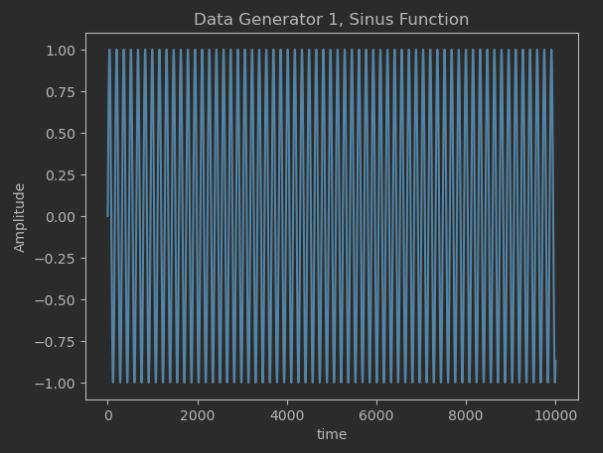

### Data generator 2
Für den zweiten Kunden wurden echte Heizdaten verwendet. Es handelt sich um Zeitintervall Daten, auf die genauen Bedeutungen der Abkürzungen wird hier verzichtet.

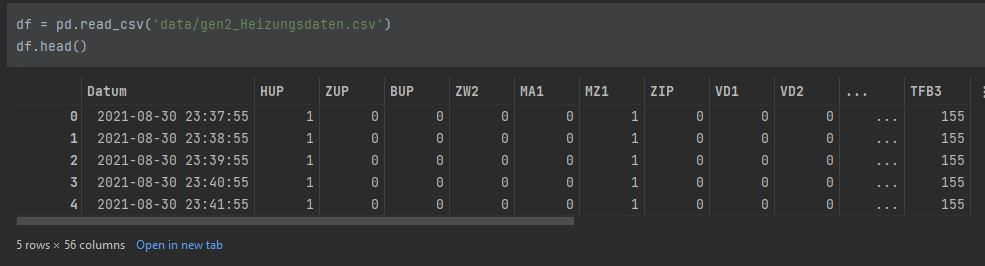

#### Exercise 6.
Das Jupyter Notebook 'data_producer_1', 'data_producer_2', 'data_consumer1', 'data_consumer2' senden und empfangen Daten über Kafka. Die empfangenen Daten werden in einem csv-file gespeichert.

#### Exercise 7.
Folgend kurze Übersicht zum Aufbau der Anwendung

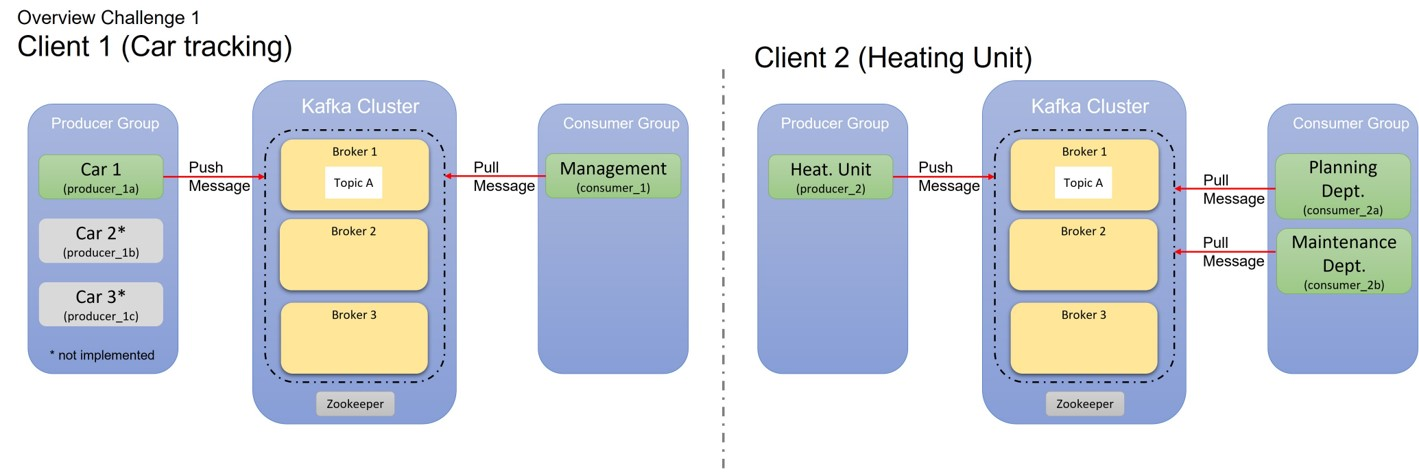

**What are the tasks of the components?**
1. Producer: Generiert die Daten die zu versenden sind. Erstellt die Verbindung zu Kafka und sendet die Nachrichten innerhalb eines Topics.
2. Kafka: Kafka ist ein Nachrichtensystem, es versendet Nachrichten innerhalb seiner Plattform. Ein Publish-Subscriber System, die Daten die verschickt werden, werden im Gegensatz zu anderen Systemen auf der Kafka Plattform gespeichert. Geht eine Abfrage der Daten schief, sind die Daten nicht verloren und können erneut abgeholt werden (drei Wochen Speichergrenze).
3. Broker: Kafka hat Speicher Layers, namentlich Broker. Broker verteilen die eintreffenden Nachrichten. Für grössere Anwendungen können, bezüglich Skalierbarkeit und Zuverlässigkeit, mehr Broker verwendet werden.
4. Topics: Topics werden verwendet, um Nachrichten eines Kanals zuzuordnen. Neue Nachrichten eines Kanals werden dem Topic angefügt. Topics können als Ordnersystem gesehen werden, die Files oder eben Nachrichten enthalten. Ein Topic wird mit dem Replikationsfaktor >= 2 auf mehrere Broker repliziert.
5. Partition: Ein Topic kann in mehrere Partitionen unterteilt werden. Die Partitionen sind der fundamentale Mechanismus, diese lassen Parallelisierung zu und ermöglichen einen sehr hohen Nachrichtenfluss.
6. Consumer: Die Konsumenten (Subscriber) lesen die Nachrichten, die auf einem Topic eintreffen. Subscriber arbeiten unabhängig und können laufend auf Nachrichten warten oder diese sporadisch abfragen.

**Funktionsweise der Anwendung (Ausführung)**

Um die Anwendung zu starten folgendes Vorgehen:
1. docker-compose up -- build ausführen und Docker Container starten
2. Jupyter Container öffnen (Container log öffnen, auf den Link mit Token klicken)
3. Jupyter Umgebung startet um Browser, öffne alle Notebooks
4. Die Producer Notebooks starten (print Meldungen prüfen)
5. Die Consumer Notebooks starten (print Meldungen prüfen)
6. In Kafka_drop können die Nachrichten auf dem Topic "data_gen1" und "data_gen2" auch angesehen werden

Die Notebooks "data_producer_1a" und "data_producer_2" lesen von den hinterlegten csv-files und übergeben die Daten an Kafka (Push Message). Führe die Notebooks aus und prüfe, ob die Daten erfolgreich verschickt werden ("Message published successfully to topic: data_gen1").
In den data_consumer Notebooks werden die Daten wieder aus Kafka gelesen (Pull Message). Die Empfänger/Consumer können in unterschiedlichem Zeitabständen die Daten von Kafka lesen. Der Kunde mit den GPS Daten erhält Echtzeitdaten. Für den Kunden mit den Heizungsdaten werden alle 2 Sekunden Daten verschickt, consumer2a holt die Daten alle 4 Sekunden während consumer2b die Daten nur alle 10 Sekunden benötigt. (Zeitdauer wird derzeit mit einem Wihle-Loop und einem Sleep umgesetzt)
Die Consumer werden beendet, wenn die Producer keine neuen Daten mehr versenden, bei neuen Daten müssen daher auch die Consumer neu gestartet werden. Dies wurde eingebaut, um die Schleifenprozesse einfacher zu beenden (Producer beenden reicht). In der Praxis würde der Leseprozess wohl auf neue Daten Warten resp. weiter laufen.

Bugs:
Wenn derzeit die Consumer Notebooks neu gestartet werden, werden alle Daten, die in der Kafka Queue vorhanden sind, erneut eingelesen und gespeichert. Bei einem Neustart wird ein neuer Consumer erstellt womit, alle Messages von Kafka erneut gelesen werden. Es wurde versucht mit einer "client_id" einen Consumer "anzumelden" um die Daten seit der letzten Anfrage zu erhalten. Dies reichte offenbar jedoch nicht. Lösungsansatz: Neben der client_id, muss auch eine group_id und enable.auto.commit==True gesetzt werden. Danach wird der Offset (Position letzt Nachricht gelesen) gespeichert. Für Consumer2a und Consumer2b würden zwei unterschiedliche Gruppen erstellt werden. Falls mehrere Consumer in einer Gruppe sind, müsste der Producer2 die Nachrichten auch in zwei Partitionen ablegen. Es gilt, die Anzahl Partitionen >= Gruppengrösse, [quelle](https://www.stackchief.com/questions/What%20is%20Kafka%20Consumer%20Group%20ID%3F).

In Planung:
- derzeit keine Partitionen für Topics vergeben, könnte für das Topic "data_gen2" und deren Consumer Groupen notwendig sein.
- die empfangenen Daten werden in einem File gespeichert und könnten verloren gehen, wenn im Container kein Volume angelegt wurde. Ein Script welches die Daten vom Container herunterlädt wäre nützlich. (Port Container definieren, File herunterladen)


#### Bonus
Use other serializers/deserializers instead of JSON for the messages.

## Part  2 - Communication Patterns
In der Aufgabenstellung soll eine Alternative zu Kafka implementiert werden. Da für mich Kafka neu ist und von Part 1 noch ein paar Bugs und nützliche Erweiterungen offen sind, würde ich hier gerne die Kenntnisse zu Kafka und Docker vertiefen und weiter Optionen ausprobieren. Somit wird für Part2 weiterhin Kafka verwenden, RabbitMQ wird eingelesen aber vorläufig nicht implementiert.

#### Exercise 2.
Pack your rewritten application into containers. Describe the used containers and how they interact with each other using a diagram.

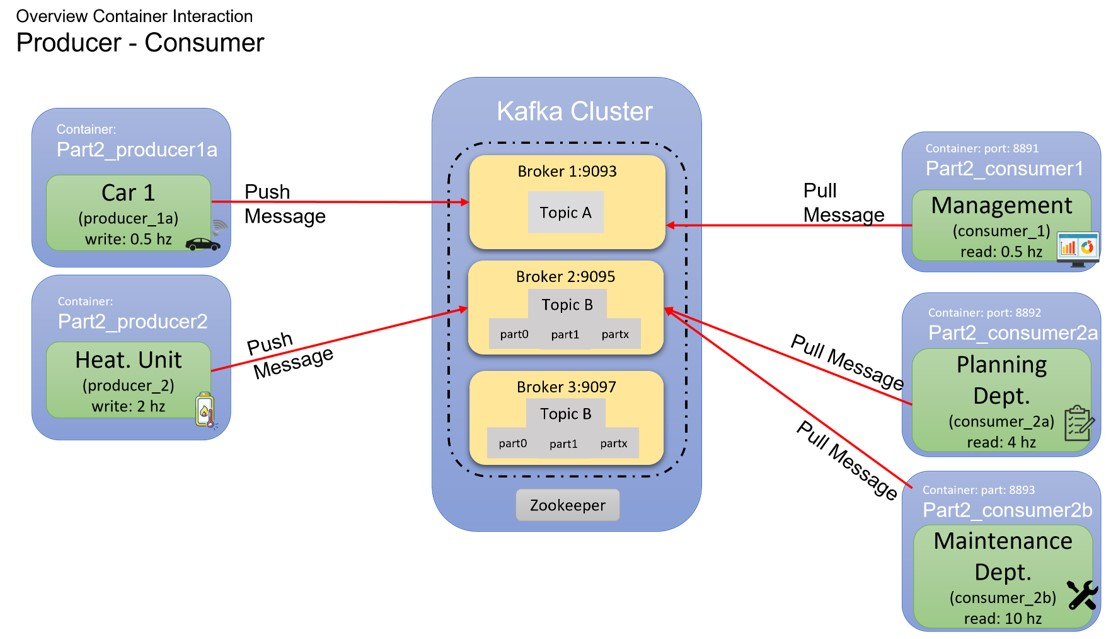

Die einzelnen Docker Container sollen die unabhängigen Prozesse darstellen. Verschiedene Fahrzeuge (part2_producer1a) und Heizungen (part2_producer2) generieren Daten und senden dies über Netzwerke an Kafka. Diese Prozesse laufen unabhängig und kontinuierlich. Die Verarbeitungs- und/oder Leseprozesse werden in separate Container aufgebaut. Im Planungsabteilung (part_consumer2a) werden die Daten gelesen und in einem File gespeichert, während das Wartungsabteilung die Daten lediglich liest. Die Consumer können, zum Beispiel für Wartungszwecke, ohne Probleme gestoppt werden. Bei einem Neutstart werden die letzten noch nicht erhaltenen Daten von Kafka gelesen (Daten bis 2 Wochen in Kafka zur Verfügung).

Alle Container haben eine gemeinsame Schnittstelle, Kafka. Die Consumer Seite ist indirekt von den Producern abhängig, insofern dass die Producer Daten generieren sollten, aber es bestehen keine Abhängigkeiten innerhalb der Container und deren Umgebung (Dependencies and stuff).
Folgende Startabhängigkeiten wurden für das docker-compose file festgelegt:
1. starten der Broker
1. starten der Producer
1. starten der Consumer (nicht zwingend notwendig, Consumer können auf Daten warten)

Da ein compose file verwendet wurde, wurden alle Container praktischerweise im selben Netzwerk angelegt. Für Container ausserhalb müsste ansonsten ein Netzwerk angelegt werden.



**Ausführen Software Part 2**
Führe "docker-compose up" aus. Die Container werden entsprechend der Übersichtsgrafik aufgebaut und gestartet. Um die Funktionsfähigkeit zu prüfen, können die einzelnen Container im Docker Windows geöffnet werden. In der Konsole der jeweiligen Container werden, nach einer startup phase, verschiedene Meldungen zu den Nachrichten und weitere Zustände angezeigt.

**Verbesserungen / Anpassungen**

Bugs:
- (behoben) Die consumer files starten nicht automatisch, werden derzeit von Hand gestartet (docker windows -> CLI -> "python data_consumer1.py"). container console und python print werden nicht in echtzeit verarbeitet. print(, flush=True) behebt dies. Wie regelmässig print Statements eines Pythonobjekts gezeigt werden, kann im image file definiert werden.
- (behoben) Der while loop der Consumer files hängt. Consumer1: while loop und "consumer_timeout_ms" entfernt, Consumer2a/2b: Um das gewünschte Zeitintervall mit dem while loop zu erstellen sollte die "consumer_timeout_ms" Zeit kleiner als die der Producer sein.

In Planung:
- derzeit keine Partitionen für Topics vergeben, könnte für topic 2 Sinn machen.
- die empfangenen Daten werden in einem File gespeichert und gehen verloren, wenn der Container neu gestartet wird. Ein Script welches die Daten vom Container herunterlädt wäre nützlich. (Port Container definiert)
- Welche Vorteile bringen Subscriber Gruppen?

#### Exercise 3.

**Die Vorteile**
von Publish-Subscriber Kommunikation Systemen ist das Reduzieren von Abhängigkeiten oder die Entkopplung von Applikationsteilen. Die Publisher-seite kann sich auf das Veröffentlichen von Daten konzentrieren (Message -> Topic). Je nach Einstellungen können Rückmeldungen der Subscriber verlangt werden, um zu prüfen, ob die Daten angekommen sind. Die Subscriber schreiben sich für die Topics ein, die für sie relevant sind. Es können beliebig Subscriber dazukommen oder fernbleiben.

**Die Nachteile**
sind wohl das Prüfen, ob die Nachrichten komplett und korrekt beim Subscriber angekommen ist. Garantieren kann der Publisher dies durch die Entkopplung der Systeme nicht mehr. Es gibt verschiedene Einstellungen die Antworten von Subscriber fordern und dies prüfen können. Muss aber auf eine Antwort des Subscribers gewartet werden, kostet dies Zeit. Auch sind sensible Daten, wie kritische Probleme oder Fehler, stärker von diesem Nachteil betroffen und Daten könnten evtl. nicht zeitnah bei den Teilnehmern ankommen. Weiter ist der Ausfall von Publisher, wenn nicht regelmässig Daten versendet werden, ein Problem. Für die Teilnehmer ist es sehr schwierig einen solchen Ausfall zu bemerken.

**Die Skalierbarkeit**
in Kafka kann mit zusätzlichen Brokern umgesetzt werden (horizontales skalieren, meistens verwendet). Die Performance der Broker kann auch durch Erhöhen der Partitionen von Topics verbessert werden (vertikales skalieren). Ein Publish-Subscriber System skaliert wesentlich besser als ein Verteilsystem, bei dem die Empfänger einzeln behandelt werden (Mail/SMS an 10000 Kunden senden).

#### Bonus
Show how your container setup could be integrated into a container orchestration system (such as Kubernetes) and how it would profit from this. Or show how you could replace some components with cloud-based offers and what changes/considerations come with this.

## Part 3 - Performance Analysis and Evaluation
1. Change the scalability of your communication framework by changing the used resources. (E.g.: add brokers and/or zookeepers and play with parameters in the docker-compose file. Use orders of magnited more producers/consumers.) Perform 2-3 experiments with different configurations. Document your experiments and their results appropriately (e.g. by video recording). Discuss the results in about 200 words.

**Experimente**
In den folgenden Versuchen soll getestet werden, welchen Nachrichtenfluss Kafka mit unterschiedlicher Anzahl Broker aufrechterhalten kann. Die Anzahl Nachrichten werden künstlich vervielfacht, der "Producer2" im Compose-File wird dafür mehrfach in separate Container dupliziert und die Sendefrequenz auf 0.01 Sekunden heruntergesetzt.

Um den Nachrichtenfluss zu messen wurde ein Topic `Performance` aufgesetzt. Direkt nachdem der Producer2 seine Daten versendet hat, wird auf dem Topic `Performance` den Zeitpunkt des versendens sowie dem hostnamen publiziert. Durch das Vervielfachen des Producer2 mit mehreren Containern, wird der Hostname benötigt, um zwischen den Producern unterscheiden zu können. Derzeit nicht benötigt da die gesamt Summe der Nachrichten geprüft werden, der Nachrichtenfluss je Producer aber evtl. auch interessant.

Ausführen der Versuche:
1. Das Compose-File wird entsprechend den Versuchen A-H angepasst.
2. Mit `docker-compose up --build` die Images neu bauen und die Container starten
3. Im Container  `jupyter_perf` das Notebook starten, dieses zeigt den Nachrichtenfluss an und aktualisiert sich alle fünf Sekunden (Achtung: Port:8880).
4. Alternativ können im Github Repo die Commits zu den einzelnen Versuchen gefunden werden.

**Folgend die Versuche:**
Versuch A. Fünf zusätzliche Producer (part3_producer3-7) wurden erstellt und drei Broker verwendet:
Resultat A: Auf dem Topic `Performance` kommen um die 400 Nachrichten / sek an. Soweit keinen Einfluss bemerkbar.

![](../part3/Performance_test_A.png)

Versuch B. Weitere sechs Producer werden erstellt (part3_producer8-13) und drei Broker verwendet:
Resultat B: Auf dem Topic `Performance` fährt der Nachrichtenfluss hoch und wird bei ca 800 Nachrichten / sek stabil. Kein Einfluss bemerkbar, die Anzahl Nachrichten pro Sekunde variieren stärker als bei Versuch A. Erhöhen der Producer um Faktor 2 lässt hier somit auch den Nachrichtenfluss um ca. den Faktor 2 steigen.

![](../part3/Performance_test_B.png)

Versuch C. "Broker4" wird beigefügt und Container neu gestartet, totale Broker = 4:
Resultat C: Auf dem Topic `Performance` fährt der Nachrichtenfluss hoch und wird wieder bei ca 800 Nachrichten / sek stabil. Der tiefere Nachrichtenfluss beim Starten der Container kommt wohl daher, dass 12 von 13 Producer den `Broker2` als bevorzugten Broker hinterlegt haben. Da aber vier Broker zur Verfügung stehen, verteilt Kafka die Nachrichten auf alle Broker, was wohl eine gewisse Zeit dauert. Für einen sauberen start wäre es wohl von Vorteil die bevorzugten Broker gleichmässig zu verteilen.

![](../part3/Performance_test_C.png)

Versuch D. "Broker3" wird heruntergefahren, totale Broker = 3 vorhanden:
Resultat D: Der Nachrichtenfluss nimmt wenig ab, von 800 auf ca. 750 Nachrichten / sec. Der Nachrichtenfluss variiert relativ stark zwischen 600 und 800 Nachrichten / sek.

![](../part3/Performance_test_D.jpg)

Versuch E. "Broker2" wird heruntergefahren, totale Broker = 2 vorhanden:
Resultat E: Der Nachrichtenfluss fällt deutlich auf 500 Nachrichten / sek zusammen, fährt aber wieder hoch auf 800 mit derselben Spannweite wie in Test D

![](../part3/Performance_test_E.jpg)

Versuch F. "Broker1" wird heruntergefahren, totale Broker = 1 vorhanden:
Resultat F: Keine Veränderungen für ca 10 Sekunden. Nachrichtenfluss bei 750 Nachrichten / sek. Vermutlich durch den `Replikationsfaktor=2` muss Kafka die Nachrichten nicht mehr verteilen. Nach 10 Sekunden bricht Broker 1 zusammen, Nachrichtenfluss fällt auf 0 mit einzelnen Nachrichten und behält diesen Status. Ein einzelner Broker kann die Applikation nicht handhaben. Je nach Anwendungsfall sollte die Applikation auch einen Fehler werfen, wenn der Replikationsfaktor nicht erreicht werden kann. Die Defaulteinstellung von Kafka ist zu prüfen.

![](../part3/Performance_test_F.jpg)

Versuch G. Starten der Container mit fünf Brokern:
Resultat G: Nachrichtenfluss fährt hoch, stabil bei 800 Nachrichten / sek. Ähnlich zu Versuch A, jedoch stabiler als in Versuch B mit vier Broker und allen Producer.

![](../part3/Performance_test_G.png)

Versuch H. "Broker4" wird heruntergefahren:
Resultat H: Nachrichtenfluss kurzzeitig auf 600 Nachrichten / sek. Sehr schnell wieder stabil bei 800 Nachrichten / sek. Ausfall von Broker4 kaum spürbar.

![](../part3/Performance_test_H.jpg)

**Abschliessende Reflektion zu den Versuchen**
Aus den Versuchen wird ersichtlich, warum die Literatur mindestens drei Brokern empfiehlt. Durch den Replikationsfaktor, der >= 2 sein sollte, sind zwei Broker eigentliche schon das Minimum. Soll das System auch bei einem Broker Ausfall noch funktionieren, dann es schon mindestens drei Broker. Beim Aufbauen eines Nachrichtensystems macht es wohl Sinn, die Performance oder das Verhalten des Nachrichtenflusses zu testen anhand der Anzahl Broker zu messen. Der letzte Versuch H (einer von fünf Broker fällt aus) zeigt, dass wenn genügend Kapazität vorhanden ist (Kafka nicht am Limit arbeitet) ein Broker Ausfall sehr stabil und fast unbemerkt bearbeitet wird. Ein Indiz für ein System an der Grenze könnte evtl. Versuch D und E gezeigt haben. Der Nachrichtenfluss variiert sehr stark, ein ähnliches Verhalten wurde in Versuch F gesehen, wo der Nachrichtenfluss mit nur einem Broker komplett zusammenbrach.

Wort zu Performance Messung: Die Zeitstempel der Producer werden mit einem eigenen Topic an Kafka übermittelt. Somit verursacht die Messung selbst Aufwand für die Broker. Die Nachrichten sind klein, aber es schwierig einzuschätzen wie viel Performance die Messung kostet oder ob dieser Ansatz überhaupt skalierbar wäre. Interessant wäre noch eine Auswertung des Nachrichtenflusses der Consumer, vorstellbar wären Logfiles je Consumer und diese Zeitstempel zu vergleichen.



2. Analyze the performance of your application:

A. Data generators: measure the average time incl. standard deviation required by your data generator loop over several runs and loops. Determine a reasonable number of runs and loop executions for the performance analysis.
B. Data processor: determine which call of your processor takes the most time. Which 3 methods are called the most or needed the most time and how much time?
C. Data processor: create a profile of your processor code in a processor.prof file and create 1-2 visualizations of the profile (e.g. with SnakeViz).
D. Data generators, data processor, data sink: Create a profile of memory usage and output the first 3 most memory-hungry methods.

Für die Analyse des Data Producer2 wird ein Jupyter Notebooks aus Part 1 verwendet. Um die Producer und Consumer aus dem Notebook zu starten, wurde das compose-file angepasst, respt. die zusätzlichen Container aus Part 2 auskommentiert.
1. starten des modifizierten compose-files (original Zustand)
2. jupyter notebook "data_producer_2" öffnen und die Funktionen unter "Data Producer 2 Zeit Messungen" laufen lassen.

**A.**
Für die Messung wurde [timeit](https://linuxhint.com/timeit-jupyter-notebook/) verwendet. Die Verzögerung der Sendezeit von 1 Sekunde wurde entfernt. Da die Funktion des producer_xy nicht abbricht (Daten werden kontinuierlich gesendet) wurde ein Abbruch Kriterium bei i > 5 eingebaut. Timeit führt default 100-mal die Funktion aus und berechnet den Mittelwert sowie die Standardabweichung der Laufzeit.
Die absoluten Messezeiten sind nicht sehr relevant, je nach System und dessen Auslastung werden unterschiedliche Ergebnisse erzielt. Gleiche Funktionen mit unterschiedlicher Implementations, können aber so verglichen werden. Für den Producer2 wurden folgende Messungen gemacht.

![](../part3/timeit_producer2.jpg)


**C.**
[SnakeViz](https://jiffyclub.github.io/snakeviz/) Auswertung

Der grösste Teil der Laufzeit der Funktion `produce_xy` wird für das Senden der Nachrichten aufgewendet (`publish_message`). Das vermutete Bottleneck, das Lesen der Daten mit `pandas.read_csv()`, bestätigt SnakeViz nicht. (Nachtrag:`pandas.read_csv mit` wird nicht verwendet, nur pandas.write_csv. Mit `with open` werden die Zeilen des Files schon efizient eingelesen). Da nur jeweils eine Zeile des Files gelesen und verschickt wird, taucht der Funktionsaufruf nicht mal in der Grafik auf.

Producer2
![](../part3/SnakeViz_producer2.jpg)

Consumer2a
![](../part3/SnakeViz_consumer2.jpg)

**D.**
Hierfür wurde das Package `memory_profiler` verwendet. Leider kann die Speicherauswertung nicht auf Funktionen innerhalb der Notebooks gemacht werden. Daher werden die Funktionen mit `%%file` in ein separates File geschrieben und so ausgewertet.

![](../part3/memory_profiler.jpg)



3. Did you detect bottlenecks? Describe and discuss 1-3 detected bottlenecks in about 200-300 words.

**Reflektion Part 3**
Beim Producer2 werden Zeilenweise Daten vom File gelesen und versendet. Innerhalb der Funktion `produce_xy` dauert das Senden von Nachrichten am längsten. Das Lesen der Daten hat keinen grossen Einfluss.
Die SnakeViz Analyse zum Consumer2a sind Namens technisch schwer zu interpretieren, es sieht aus als würde das Lesen der Nachrichten von Kafka die meiste Zeit benötigen (1.077 / 1.24 Sekunden). Schreiben der Daten als csv Datei belegt Platz 6 in Tabelle, benötigt aber gerade mal 0.0027 Sekunden.

Eine Analyse der Laufzeiten kann helfen, Zeitfresser zu identifizieren und Optimierungen nicht am falschen Ort anzusetzen. Für diese Anwendung würde es wohl Sinn machen, anstelle von einzelnen Zeilen, direkt grössere Datenpakete zu versenden. Der Durchsatz an Information könnte so erhöht werden.


"peak memory" wird mit ca. 110 MB gemessen, auch in memory_profiler werden 110 MB gesehen. Die einzelnen Methoden werden jeweils mit 0 MB gesehen. Das Datenfile umfasst ca. 100 MB Daten, die Vermutung liegt nahe, dass das File den Hauptteil dieser Messung ausmacht.

## Reflektion Mini-Challenge 1
1. Docker war für mich bisher ein entfernter Begriff der ab und an, an unterschiedlichen Orten aufgetaucht ist. Im Modul «gml» kam der erste Kontakt mit Docker und es wurde ohne Hintergrundwissen der Anleitung blind gefolgt. Nach «hpc» ist nun ein Docker Image oder eine Compose File zu erstellen kein Problem mehr. Auch wenn Docker wohl noch viele unbekannt Optionen bereithält, wurde in der Challenge eine solide Basis aufgebaut. Eine Herausforderung war das Debugging der Image-, Compose- und Pythonfiles. Mit den Commands `docker-compose up --build` werden die Images neu gebaut, dies wird wichtig, um Änderungen eines Images auch zu übernehmen. Mit `docker-compose down` werden Container gestoppt und gelöscht. Mit diesen Commands können schnell verschiedene Sachen ausprobiert werden (Docker Windows-Desktop Container via Klicken entfernen ist nicht schnell – Danke Joe).
2. Der Umgang mit Kafka war sehr spannend. Kafka bietet viele Optionen und viel Unterstützung, um Nachrichten schnell und sicher zu verteilen, ein paar wurden in dieser Challenge ausprobiert. Leider konnte aus Zeitgründen die Mechanik von mehreren Partitionen eines Topics nicht umgesetzt werden. Die Daten parallel schneller zu schreiben und mit Consumer Gruppen zu lesen wäre noch interessant gewesen. Die Resultate der Performance Messung (Grafik zu gesendeten Nachrichten / Sekunde) sind mit Vorsicht zu interpretieren. Die Performance Messung schreibt auf ein separates Topic, was für Kafka (wohl nicht viel aber) eine zusätzliche Belastung ist. Eine Messung ohne Systemeinfluss wäre wohl besser. Zudem beeinflussen andere Anwendungen auf dem Computer wohl auch die Leistung, die für Kafka zur Verfügung steht.
Kafka_drop besitzt offenbar bestimmte Metriken die abgegriffen werden können (im log output ersichtlich), dies wurde aber im Rahmen dieser Challenge nicht mehr weiterverfolgt.
Dennoch konnten anhand verschiedener Versuche, den Einfluss auf den Nachrichtenfluss ausprobiert werden.
Im dritten Teil wurden Zeit- und Memory Messungen durchgeführt. Für meine bescheidene Anwendung sind die Verbesserungsmöglichkeiten ein wenig gering. Es ist jedoch gut gesehen zu haben, welche Testmöglichkeiten zur Verfügung stehen.

3. Auch sehr hilfreich waren die Code-Reviews (von Josef Weibel) und allgemein die Diskussionen mit den Mitstudierenden und dem Fachexperte. Unterschiedliche Ansätze, Ideen und Lösungen konnten diskutiert werden.

4. Änderungen zur Challenge: Für mich schwierig war ein wenig der sofortige Start in die Challenge. Das Coding legt direkt los und als Anfänger bleibt keine Zeit die Theorie zu bearbeiten. Theorie nachlesen passiert dann zu spezifischen Problemen, aber gefühlt fehlt dann etwas die zusammenhängende Theorie. In der Mediatheke sind mehrere Bücher und weitere Unterlagen verlinkt, bin nicht sicher inwiefern diese neben der Challenge auch bearbeitet werden können. Die Zeit- und Memory Aufgaben waren etwas schwierig um zusetzten, dieses Thema verkürzen und dafür Multitreads / Multiprocessing anschaunen wäre spannend.




ende - mini challenge 1